# Kernel Density -- Earthquake Dataset

Keenan and James

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

quakes = pd.read_csv("./data/data.csv")

print quakes.head()

                       time  latitude  longitude  depth  mag magType  nst  \
0  1901-08-09T18:33:00.000Z        40        144      0  7.5      mw  NaN   
1  1901-08-09T13:01:00.000Z       -22        170      0  7.9      mw  NaN   
2  1902-04-19T02:23:00.000Z        14        -91      0  7.5      mw  NaN   
3  1902-09-23T20:18:00.000Z        16        -93      0  7.8      mw  NaN   
4  1902-09-22T01:46:00.000Z        18        146      0  7.5      mw  NaN   

   gap  dmin  rms    ...                      updated  \
0  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
1  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
2  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
3  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
4  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   

                                       place        type horizontalError  \
0        off the east coast of Honshu, Japan  earthquake             NaN   
1           southeast of the Loyalty Islan

We wrote some helper functions that will help us test the progress we have made in the models quickly.

In [3]:
from sklearn.cross_validation import train_test_split

def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

### Features

In [4]:
def magclassify(mag):
    if mag < 4:
        return 0
    elif mag < 5:
        return 1
    elif mag < 6:
        return 2
    elif mag < 7:
        return 3
    elif mag < 8:
        return 4
    elif mag >= 8:
        return 5
# "minor" "light" "moderate" "strong" "major" "great"      
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [5]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])

In [6]:
add_features()

In [7]:
logistic = LogisticRegression()
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.78356779355079131

In [8]:
predictors = ["latitude", "longitude", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.80397049061965042

In [17]:
predicted = np.array(alg.predict_proba(X_test))

print predicted.shape

(343484, 6)


 - computing KDE in spherical coordinates
 - plot coastlines using basemap
 - computing KDE in spherical coordinates
 - plot coastlines using basemap


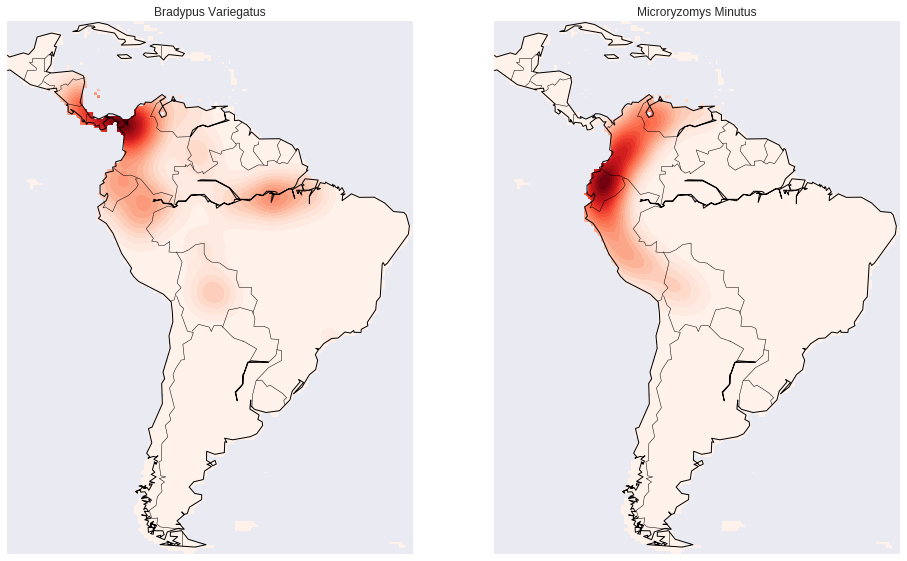

In [15]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
plt.figure(figsize=(16,12))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = -9999 + np.zeros(land_mask.shape[0])
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    print(" - plot coastlines using basemap")
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c')
    m.drawcoastlines()
    m.drawcountries()

    plt.title(species_names[i])

plt.show()